In [1]:
import pandas as pd
import ete3
import re
import community
import networkx as nx
import itertools
import numpy as np
from sklearn import manifold
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
import igraph as ig
import plotly
import chart_studio.plotly as ptl
import plotly.graph_objects as go
import colorlover as cl
from IPython.display import HTML
import multiprocessing
import pickle as pkl
import random
from sklearn import mixture
from collections import Counter

ptl.sign_in('lthiberiol', 'm15ikp59lt')
ncbi = ete3.NCBITaxa()
%cd /work/eggNOG/

/work/eggNOG


In [2]:
sampled_genomes = pd.read_csv('/work/kelsey/genomes.tab',
                              sep='\t',
                              index_col=0)

In [3]:
lineages = pd.DataFrame()
for taxid in sampled_genomes.species_taxid.unique():
    if pd.isna(taxid):
        continue
    lineages = lineages.append({tax_rank: tmp_taxid 
                                 for tmp_taxid, tax_rank in ncbi.get_rank(ncbi.get_lineage(taxid)).items()},
                                ignore_index=True)
lineages = lineages.reindex(columns=['class', 'family',  'genus', 'phylum',
                                     'order', 'species', 'superkingdom']).copy()
lineages = lineages.query('superkingdom == 2').copy()

In [4]:
eggNOG_sample = pd.read_csv('e5.bacteria.taxid_info.tsv',
                            sep='\t',
                            comment='#',
                            names=['Taxid', 'Sci.Name', 'Rank', 'Named Lineage', 'Taxid Lineage'],
                            header=None,
                            index_col=0)

In [5]:
eggNOG_lineage = pd.DataFrame()
for taxid in eggNOG_sample.index.unique():
    if pd.isna(taxid):
        continue
    tmp = pd.Series({tax_rank: tmp_taxid 
                     for tmp_taxid, tax_rank in ncbi.get_rank(ncbi.get_lineage(taxid)).items()})
    tmp.name = taxid
    eggNOG_lineage = eggNOG_lineage.append(tmp)

eggNOG_lineage = eggNOG_lineage.reindex(columns=['class', 'family',  'genus', 'phylum',
                                                 'order', 'species', 'superkingdom']).copy()
eggNOG_lineage = eggNOG_lineage.query('superkingdom == 2').copy()

eggNOG_target_phyla = eggNOG_lineage[eggNOG_lineage.phylum.isin(lineages.phylum.unique())]

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 1344012 was translated into 480813

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 443255 was translated into 1901

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 1525715 was translated into 1545044

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 861530 was translated into 29382

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 1317118 was translated into 1379903

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 67281 was translated into 67351

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/

In [6]:
eggNOG_groups = pd.read_csv('2_members.tsv',
                            sep='\t',
                            header=None,
                            usecols=[1,2,3,4],
                            names=['group_id', 'num_proteins', 'num_taxa', 'members'])

tmp           = eggNOG_groups.members.map(lambda cell: [int(taxid) 
                                                        for taxid in re.findall('(\d+)\.(?:[^,]+)', cell)])
tmp.name      = 'taxa'
eggNOG_groups = eggNOG_groups.join(tmp)

In [7]:
def get_phyla_overlap(taxa):
    #taxids = [int(_) for _ in taxa]
    group_phyla = set(eggNOG_lineage.loc[taxa, 'phylum'].unique())
    overlapped_phyla = group_phyla.intersection(lineages.phylum.unique())
    return(overlapped_phyla)

eggNOG_target_groups = eggNOG_groups[eggNOG_groups.taxa.map(lambda cell: 
                                                            True if len(get_phyla_overlap(cell)) > 1 
                                                            else False)]

In [8]:
eggNOG_trees = pd.read_csv('2_trees.tsv',
                           sep='\t',
                           header=None,
                           usecols=[1,2,3],
                           index_col=0,
                           names=['group_id', 'fast', 'tree'])
eggNOG_trees = eggNOG_trees.reindex(index=eggNOG_target_groups.group_id)

In [619]:
eggNOG_chloroflexi = eggNOG_lineage.query('phylum==200795').index
eggNOG_cyano       = eggNOG_lineage.query('phylum==1117'  ).index

chloroflexi_count = eggNOG_target_groups.taxa.map(lambda x: len(eggNOG_chloroflexi.intersection(set(x))))
cyano_count       = eggNOG_target_groups.taxa.map(lambda x: len(eggNOG_cyano.intersection(set(x))))

In [620]:
# groups interesting to test distances between cyano and chloroflexi
test_groups = eggNOG_target_groups[(chloroflexi_count>=10) & (cyano_count>=70)]

In [622]:
test_groups = test_groups[test_groups.num_proteins<10_000]

In [623]:
test_groups.shape

(847, 5)

In [502]:
def get_pairwise_distances(group_id):
    
    tree = ete3.Tree(eggNOG_trees.loc[group_id, 'tree'])

    leaf_names = []
    for count, node in enumerate(tree.traverse()):
        if node.is_leaf():
            leaf_names.append(node.name)
        else:
            node.name = 'node_%i' % count
    leaf_names = np.array(leaf_names)

    nodes         = []
    children      = []
    branch_length = []
    for node in tree.traverse():
        if not node.is_leaf():
            for child in node.get_children():
                nodes.append(         node.name)
                children.append(     child.name)
                branch_length.append(child.dist)

    branch_length_df                  = pd.DataFrame()
    branch_length_df['node']          = nodes
    branch_length_df['child']         = children
    branch_length_df['branch_length'] = branch_length

    dag  = ig.Graph.TupleList(edges=branch_length_df[['node', 
                                                      'child', 
                                                      'branch_length']].itertuples(index=False), 
                                directed=False, 
                                weights=True)
    
    dist_matrix = pd.DataFrame(index  =leaf_names, 
                               columns=leaf_names, 
                               data   =np.array(dag.shortest_paths(source=leaf_names, 
                                                                   target=leaf_names, 
                                                                   weights='weight'))
                              )
    return(dist_matrix)

In [562]:
def create_taxa_graph(dist_matrix, phyla):
    triu_indices       = np.triu_indices_from(dist_matrix, k=1)
    
    edge_list                 = pd.DataFrame()
    edge_list['phylum1']      = phyla[triu_indices[0]]
    edge_list['phylum2']      = phyla[triu_indices[1]]
    edge_list['sequence1']    = dist_matrix.index[triu_indices[0]]
    edge_list['sequence2']    = dist_matrix.index[triu_indices[1]]
    edge_list['distance']     = dist_matrix.values[triu_indices]
    edge_list['inverse_dist'] = np.e**np.negative(edge_list.distance)

    graph  = ig.Graph.TupleList(edges=edge_list[['sequence1', 
                                                 'sequence2', 
                                                 'inverse_dist']].itertuples(index=False), 
                                directed=False, 
                                weights =True)
    
    return(edge_list, graph)

In [908]:
def get_phyla_evol_distances(group_id):
    
    dist_matrix = get_pairwise_distances(group_id)

    taxids = [int(leaf.split('.')[0]) for leaf in dist_matrix.index]
    phyla  = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

    edge_list, graph  = create_taxa_graph(dist_matrix, phyla)

    clusters = graph.community_multilevel(weights='weight')

    node_data = pd.DataFrame(columns=['name', 'phylum', 'cluster'],
                             data   =zip(dist_matrix.index, 
                                         phyla, 
                                         clusters.membership)
                            )

    family_cyano_count = sum(node_data.phylum==1117)
    
    cluster_evol_relations = {}

    for cluster_num in set(clusters.membership):
        cluster_nodes = node_data[node_data.cluster==cluster_num]

        if sum(cluster_nodes.phylum==1117) < family_cyano_count*0.3:
            continue

        cluster_dists = pd.DataFrame(columns=['phylum', 'median', 'distances'])
        
        cluster_edges = edge_list.loc[(edge_list.sequence1.isin(cluster_nodes.name))&
                                      (edge_list.sequence2.isin(cluster_nodes.name)),
                                      ['phylum1', 'phylum2', 'distance']]

        minimal_freq_phyla = [phylum for phylum, frequency in Counter(cluster_nodes.phylum).items() if frequency>=5]
        cluster_edges      = cluster_edges[(cluster_edges.phylum1.isin(minimal_freq_phyla)) &\
                                           (cluster_edges.phylum2.isin(minimal_freq_phyla))]
        normalizer         = np.median(cluster_edges.distance)
        cluster_edges      = cluster_edges[cluster_edges.phylum1 != cluster_edges.phylum2] 

        threshold      = np.infty
        closest_phylum = None
        for phylum1, phylum2 in itertools.combinations(minimal_freq_phyla, 2):
            if indices.shape[0] < 10:
                continue
            if   phylum1 == 1117:
                phylum = phylum2
            elif phylum2 == 1117:
                phylum = phylum1
            else:
                continue

            inter_phyla_dists = cluster_edges.loc[((cluster_edges.phylum1==phylum1)&(cluster_edges.phylum2==phylum2))|\
                                                  ((cluster_edges.phylum2==phylum1)&(cluster_edges.phylum1==phylum2)), 
                                                  'distance'].values
            inter_phyla_dists.sort()

            try:
                phylum_3rd_quartile = np.median(inter_phyla_dists)
            except IndexError:
                continue        

            cluster_dists = cluster_dists.append(pd.Series(data=[phylum, phylum_3rd_quartile, inter_phyla_dists], 
                                               index=['phylum', 'median', 'distances']),
                                     ignore_index=True)

        cluster_evol_relations[cluster_num] = cluster_dists
    
    return(group_id, cluster_evol_relations)

In [909]:
get_phyla_evol_distances('COG0499')

('COG0499', {2:                  phylum    median  \
  0                   976  9.397056   
  1                  1224  5.981892   
  2                201174  4.503246   
  3                  1239  3.072651   
  4                200795  1.588374   
  5  -9223372036854775808  1.974896   
  6                508458  2.916957   
  7                200918  3.411421   
  8                200783  1.853747   
  9                200940  1.913207   
  
                                             distances  
  0  [2.2657185, 2.2913417000000003, 2.3018243, 2.3...  
  1  [1.5345805000000006, 1.5602037000000006, 1.570...  
  2  [1.6267964000000004, 1.6524196000000004, 1.654...  
  3  [1.9503405000000003, 1.9759637000000003, 1.986...  
  4  [0.9986413000000001, 1.0242645000000001, 1.034...  
  5  [1.1712678000000003, 1.196891, 1.2073736, 1.21...  
  6  [2.4532542000000004, 2.4788774000000005, 2.480...  
  7  [2.9716300000000007, 2.9717899033000004, 2.971...  
  8  [1.5208204999999997, 1.5239896000000

In [854]:
for group_id in test_groups.group_id.to_list():
# for group_id in ['COG0499']:
    print(group_id)
    
    dist_matrix = get_pairwise_distances(group_id)

    taxids = [int(leaf.split('.')[0]) for leaf in dist_matrix.index]
    phyla  = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

    edge_list, graph  = create_taxa_graph(dist_matrix, phyla)

    clusters = graph.community_multilevel(weights='weight')

    node_data = pd.DataFrame(columns=['name', 'phylum', 'cluster'],
                             data   =zip(dist_matrix.index, 
                                         phyla, 
                                         clusters.membership)
                            )

    family_cyano_count = sum(node_data.phylum==1117)
    
    cluster_evol_relations = {}

    for cluster_num in set(clusters.membership):
        cluster_nodes = node_data[node_data.cluster==cluster_num]

        if sum(cluster_nodes.phylum==1117) < family_cyano_count*0.3:
            continue

        cluster_dists = pd.DataFrame(columns=['phylum', 'median', 'distances'])
        
        cluster_edges = edge_list.loc[(edge_list.sequence1.isin(cluster_nodes.name))&
                                      (edge_list.sequence2.isin(cluster_nodes.name)),
                                      ['phylum1', 'phylum2', 'distance']]

        minimal_freq_phyla = [phylum for phylum, frequency in Counter(cluster_nodes.phylum).items() if frequency>=5]
        cluster_edges      = cluster_edges[(cluster_edges.phylum1.isin(minimal_freq_phyla)) &\
                                           (cluster_edges.phylum2.isin(minimal_freq_phyla))]
        normalizer         = np.median(cluster_edges.distance)
        cluster_edges      = cluster_edges[cluster_edges.phylum1 != cluster_edges.phylum2] 

        threshold      = np.infty
        closest_phylum = None
        for phylum1, phylum2 in itertools.combinations(minimal_freq_phyla, 2):
            if indices.shape[0] < 10:
                continue
            if   phylum1 == 1117:
                phylum = phylum2
            elif phylum2 == 1117:
                phylum = phylum1
            else:
                continue

            inter_phyla_dists = cluster_edges.loc[((cluster_edges.phylum1==phylum1)&(cluster_edges.phylum2==phylum2))|\
                                                  ((cluster_edges.phylum2==phylum1)&(cluster_edges.phylum1==phylum2)), 
                                                  'distance'].values
            inter_phyla_dists.sort()

            try:
                phylum_3rd_quartile = np.median(inter_phyla_dists)
            except IndexError:
                continue        

            cluster_dists = cluster_dists.append(pd.Series(data=[phylum, phylum_3rd_quartile, inter_phyla_dists], 
                                               index=['phylum', 'median', 'distances']),
                                     ignore_index=True)

        cluster_evol_relations[cluster_num] = cluster_dists
    
    return(group_id, cluster_evol_relations)

2Z832
  Closest to cyanos: 1239 (3.6548)
COG0001
  Closest to cyanos: 200795 (0.6786)
COG0002
  Closest to cyanos: 1239 (0.5904)
COG0003
  Closest to cyanos: 1090 (0.8019)
COG0004
  Closest to cyanos: 203682 (0.4020)
COG0005
  Closest to cyanos: 1224 (0.3089)
COG0007
  Closest to cyanos: 1224 (0.5598)
COG0008
  Closest to cyanos: 1239 (0.5169)
COG0009
  Closest to cyanos: 976 (0.5610)
  Closest to cyanos: 1224 (0.7639)
COG0010
  Closest to cyanos: 201174 (0.1319)
COG0012
  Closest to cyanos: 67819 (0.3389)
COG0013
  Closest to cyanos: 1239 (0.7408)
COG0014
  Closest to cyanos: 1239 (0.6604)
  Closest to cyanos: 57723 (0.6251)
COG0015
  Closest to cyanos: 1224 (0.3439)
COG0016
  Closest to cyanos: 976 (0.3546)
COG0017
  Closest to cyanos: 203682 (0.5396)
COG0018
  Closest to cyanos: 204428 (0.4537)
  Closest to cyanos: 976 (0.6951)
COG0019
  Closest to cyanos: 1239 (0.3249)
COG0020
  Closest to cyanos: 57723 (0.7605)
COG0021
  Closest to cyanos: 1224 (0.4147)
  Closest to cyanos: 1224 (

In [857]:
yeah = deepcopy(phyla_closeness[200795])

In [858]:
for n in closest_data.loc[closest_data.phylum==200795, 'closeness'].values:
    yeah.remove(n)

In [895]:
np.min(yeah)

0.5821261495499999

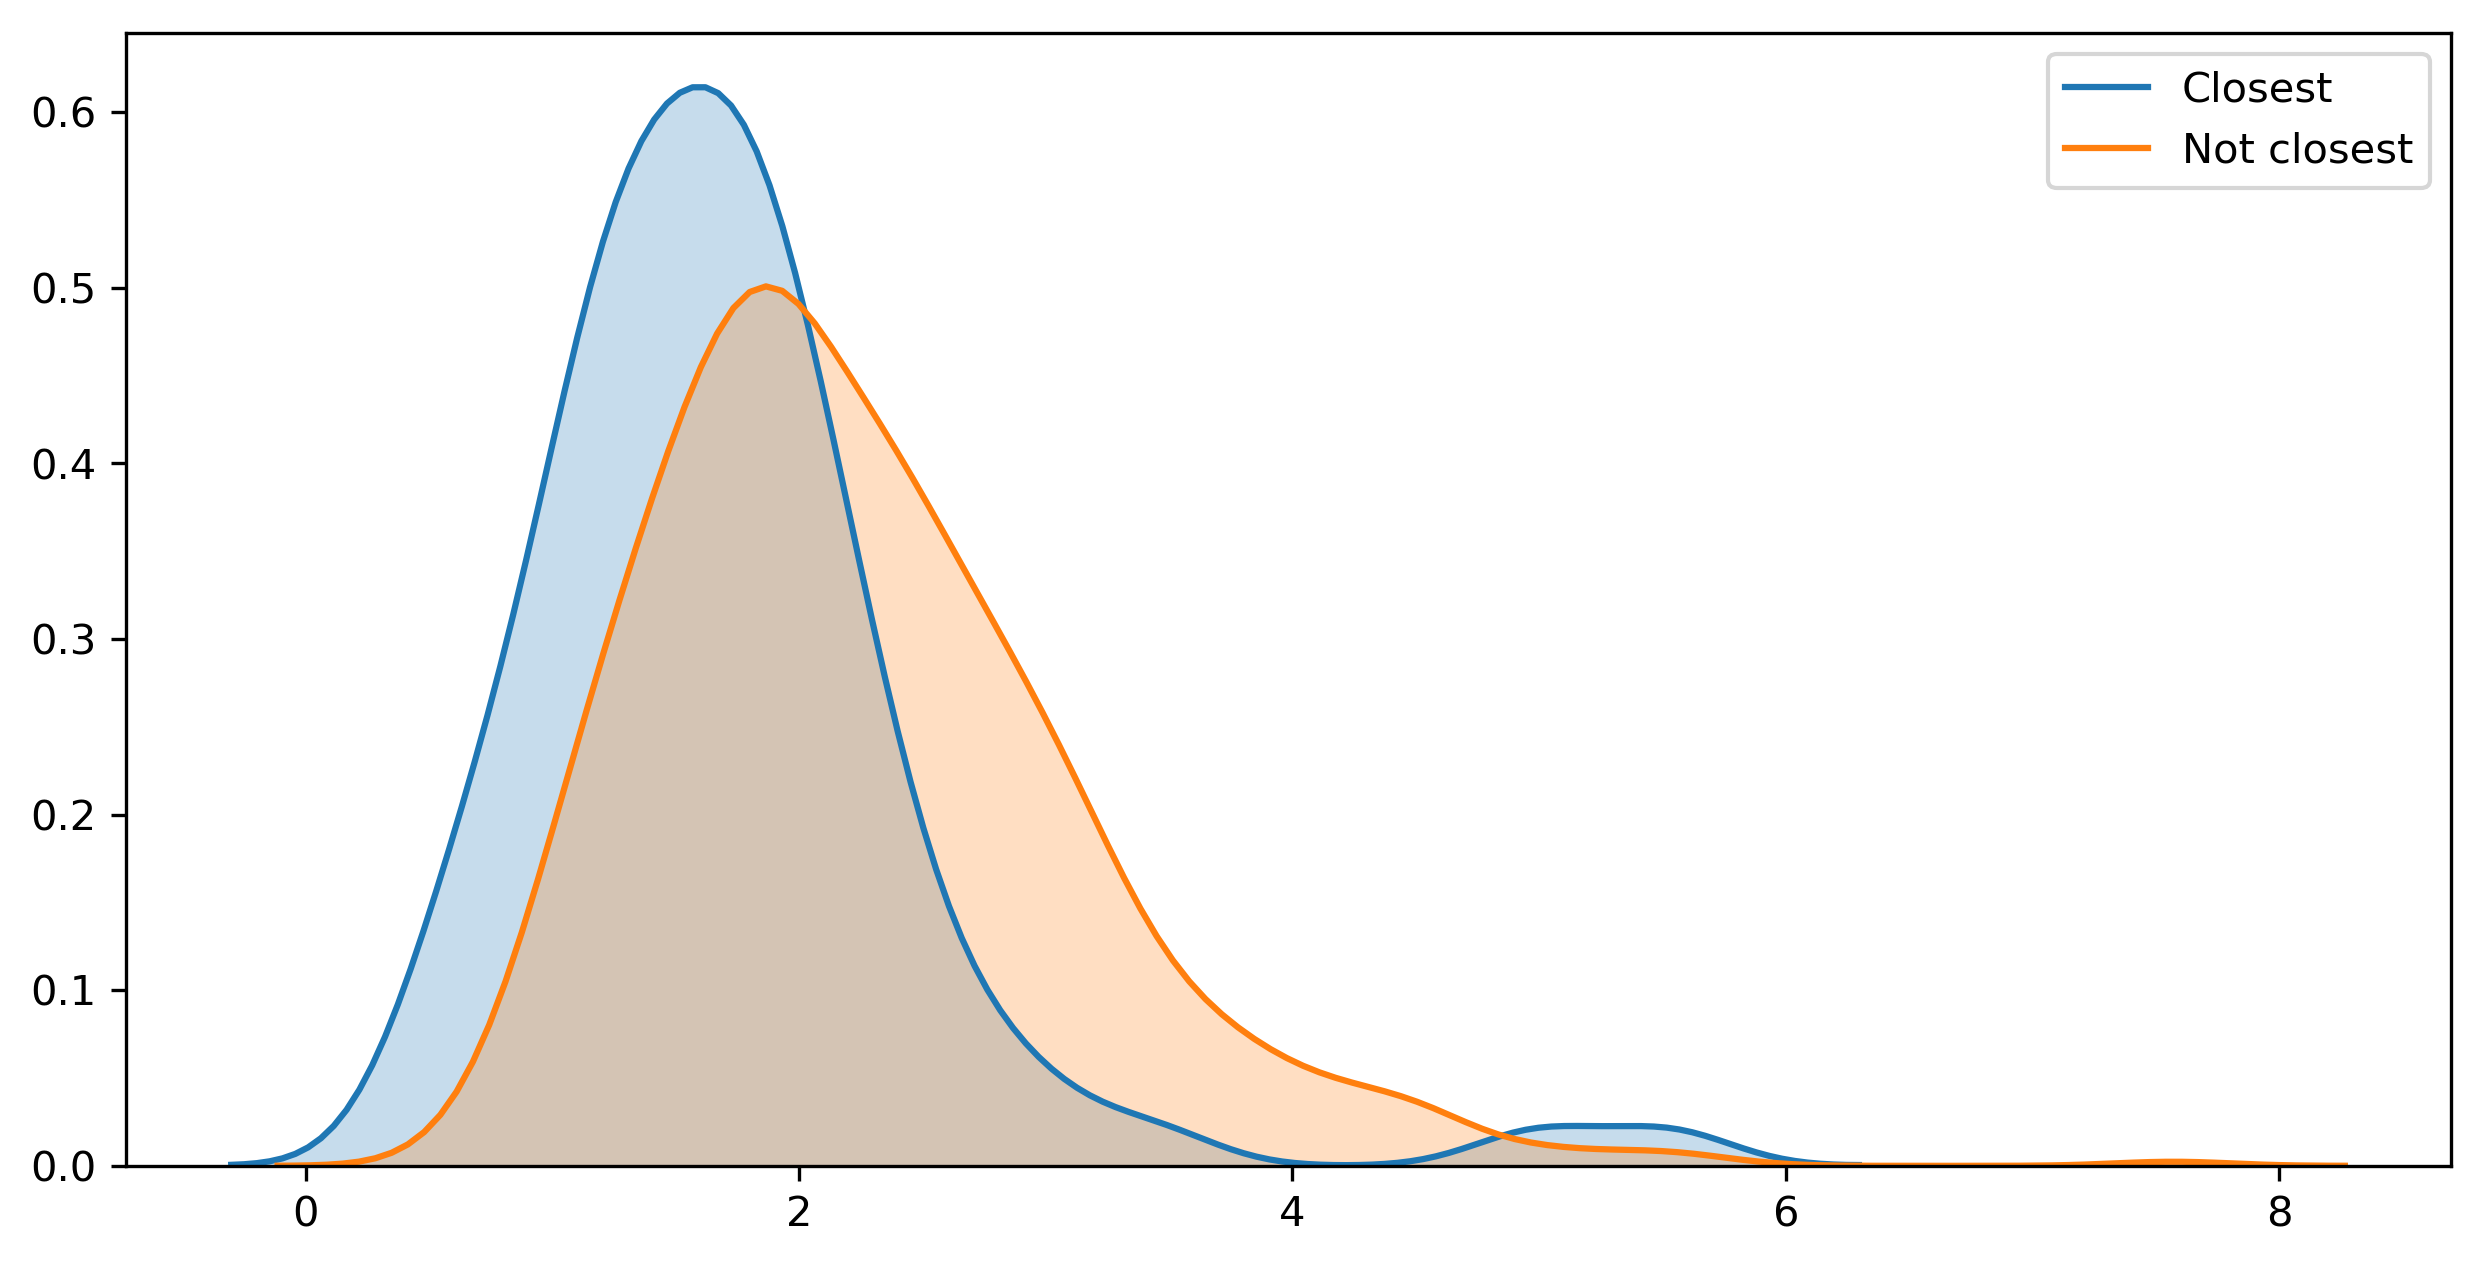

In [860]:
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

sns.kdeplot(closest_data.loc[closest_data.phylum==200795, 'closeness'], label='Closest', shade=True, ax=ax)
sns.kdeplot(yeah, label='Not closest', shade=True, ax=ax)

In [906]:
%%time
#
# test specific families
#
dist_matrix = get_pairwise_distances('COG2343')

taxids = [int(leaf.split('.')[0]) for leaf in dist_matrix.index]
phyla  = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

edge_list, graph  = create_taxa_graph(dist_matrix, phyla)

clusters = graph.community_multilevel(weights='weight')

node_data = pd.DataFrame(columns=['name', 'phylum', 'cluster'],
                         data   =zip(dist_matrix.index, 
                                     phyla, 
                                     clusters.membership)
                        )

family_cyano_count = sum(node_data.phylum==1117)

for cluster_num in set(clusters.membership):
    print(cluster_num)
    cluster_nodes = node_data[node_data.cluster==cluster_num]
    
    cluster_dists = pd.DataFrame(columns=['phylum', '3rd_quartile', 'distances'])

    if sum(cluster_nodes.phylum==1117) < family_cyano_count*0.3:
        continue

    cluster_edges = edge_list.loc[(edge_list.sequence1.isin(cluster_nodes.name))&
                                  (edge_list.sequence2.isin(cluster_nodes.name)),
                                  ['phylum1', 'phylum2', 'distance']]

    minimal_freq_phyla = [phylum for phylum, frequency in Counter(cluster_nodes.phylum).items() if frequency>=5]
    cluster_edges      = cluster_edges[(cluster_edges.phylum1.isin(minimal_freq_phyla)) &\
                                       (cluster_edges.phylum2.isin(minimal_freq_phyla))]
    normalizer         = np.median(cluster_edges.distance)
    cluster_edges      = cluster_edges[cluster_edges.phylum1 != cluster_edges.phylum2] 
    
    threshold      = np.infty
    closest_phylum = None
    for phylum1, phylum2 in itertools.combinations(minimal_freq_phyla, 2):
        if indices.shape[0] < 10:
            continue
            
        if   phylum1 == 1117:
            phylum = phylum2
        elif phylum2 == 1117:
            phylum = phylum1
        else:
            continue
            
        inter_phyla_dists = cluster_edges.loc[((cluster_edges.phylum1==phylum1)&(cluster_edges.phylum2==phylum2))|\
                                              ((cluster_edges.phylum2==phylum1)&(cluster_edges.phylum1==phylum2)), 
                                              'distance'].values

        inter_phyla_dists.sort()

        try:
            phylum_3rd_quartile = np.percentile(inter_phyla_dists, 25)
        except IndexError:
            continue        
        
        cluster_dists = cluster_dists.append(pd.Series(data=[phylum, phylum_3rd_quartile, inter_phyla_dists], 
                                                       index=['phylum', '3rd_quartile', 'distances']),
                                             ignore_index=True)
        if phylum_3rd_quartile < threshold:
            threshold      = phylum_3rd_quartile
            closest_phylum = phylum

    if closest_phylum:
        print('  Closest to cyanos: %s (%.4f)' % (closest_phylum, threshold/normalizer))

0
  Closest to cyanos: 200795 (0.4830)
1
2
3
  Closest to cyanos: 200795 (0.4594)
CPU times: user 3.28 s, sys: 232 ms, total: 3.51 s
Wall time: 3.41 s


In [904]:
cluster_dists

,phylum,3rd_quartile,distances
0,200795,0.615344,"[0.34974249999999985, 0.3523355186999999, 0.35..."
1,203682,1.063082,"[0.491225, 0.5081855217999998, 0.5081855217999..."
2,201174,1.334971,"[0.4609700000000001, 0.5998614000000002, 0.626..."
3,1224,1.247231,"[0.2901103999999999, 0.3059547, 0.3143194, 0.3..."
4,1297,1.190535,"[0.8204669, 0.8496916163999999, 0.859756700000..."
5,976,1.010799,"[0.6273499959, 0.6432791958999999, 0.644310517..."
6,1239,1.528731,"[0.9458033164000001, 0.9627638381999999, 0.962..."
7,57723,1.400131,"[1.0887950959000001, 1.1057556176999999, 1.105..."


In [889]:
cluster_nodes = node_data[node_data.cluster==0]

In [891]:
cluster_nodes[cluster_nodes.phylum==200795]

,name,phylum,cluster
33,765420.OSCT_0792,200795,0
106,383372.Rcas_1654,200795,0
107,357808.RoseRS_1298,200795,0
192,324602.Caur_1361,200795,0
242,326427.Cagg_1748,200795,0
282,867845.KI911784_gene1392,200795,0
283,1521187.JPIM01000097_gene2717,200795,0


In [680]:
cluster_nodes.head()

,name,phylum,cluster
3,391593.RCCS2_16601,1224,2
5,1353537.TP2_16970,1224,2
6,530564.Psta_1310,203682,2
7,1470591.BW41_00620,1224,2
14,1550073.JROH01000007_gene1915,1224,2


In [893]:
alignment_data = []

with open('alignment/COG2343.faa', 'r') as handle:
    for entry in handle.read().split('>'):
        if entry:
            entry = entry.strip()
            alignment_data.append(entry.split('\n'))

alignment_df = pd.DataFrame(columns=['header', 'sequence'],
                            data   =alignment_data)

In [894]:
with open('alignment/COG2343-cluster2.faa', 'w') as out:
    for index, item in alignment_df[alignment_df.header.isin(cluster_nodes.name)].iterrows():
        out.write('>%s\n%s\n' % (item.header, item.sequence))

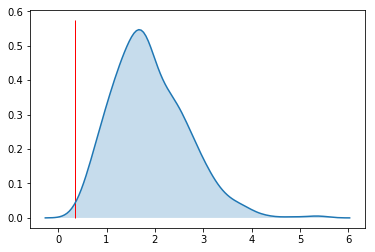

In [488]:
fig, ax = plt.subplots()
sns.kdeplot(phyla_closeness[200795], shade=True, ax=ax)
ax.fill_between(x=[0.3478], y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], color='r')

In [670]:
def visualize_in_figTree(group_id):
    tree = ete3.Tree(eggNOG_trees.loc[group_id, 'tree'], format=0)
    
    out  = open('%s.figTree' % group_id, 'w')
    out.write("#NEXUS\nbegin taxa;\n\tdimensions ntax=%i;\n\ttaxlabels\n" %len(tree))
    
    for node in tree.traverse():
        if node.is_leaf():
            taxid, locus_tag = node.name.split('.')
            try:
                lineage = {j: i for i, j in ncbi.get_rank(ncbi.get_lineage(taxid)).items()}
            except ValueError:
                out.write('\t%s\n' %(node.name))
                continue
            else:
                lineage_names = ncbi.get_taxid_translator(lineage.values())

            out.write('\t%s ' %(node.name))
            comment = []
            for rank in ['class', 'phylum', 'order', 'family', 'species']:
                if rank in lineage:
                    comment.append('tax_%s="%s"' %(rank, lineage_names[lineage[rank]]))
            out.write('[&%s]\n' %' '.join(comment))

    newick_text = tree.write(format=0)
    out.write(';\nend;\n')
    out.write('begin trees;\n\ttree tree_1 = [&R] %s\nend;' %newick_text)
    out.close()

In [866]:
visualize_in_figTree('COG2343')

In [899]:
tree = ete3.Tree('alignment/COG2343-cluster0.aln.treefile', format=0)

out  = open('COG2343-cluster0.figTree', 'w')
out.write("#NEXUS\nbegin taxa;\n\tdimensions ntax=%i;\n\ttaxlabels\n" %len(tree))

for node in tree.traverse():
    if node.is_leaf():
        taxid, locus_tag = node.name.split('.')
        try:
            lineage = {j: i for i, j in ncbi.get_rank(ncbi.get_lineage(taxid)).items()}
        except ValueError:
            out.write('\t%s\n' %(node.name))
            continue
        else:
            lineage_names = ncbi.get_taxid_translator(lineage.values())

        out.write('\t%s ' %(node.name))
        comment = []
        for rank in ['class', 'phylum', 'order', 'family', 'species']:
            if rank in lineage:
                comment.append('tax_%s="%s"' %(rank, lineage_names[lineage[rank]]))
        out.write('[&%s]\n' %' '.join(comment))

newick_text = tree.write(format=0)
out.write(';\nend;\n')
out.write('begin trees;\n\ttree tree_1 = [&R] %s\nend;' %newick_text)
out.close()